In [9]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('fivethirtyeight')

import seaborn as sns 

In [10]:
file_path ='C:/Users/82109/Downloads/olist_dataset/'
df_customers = pd.read_csv(file_path + 'olist_customers_dataset.csv')
df_geolocation = pd.read_csv(file_path + 'olist_geolocation_dataset.csv')
df_orders = pd.read_csv(file_path + 'olist_orders_dataset.csv')
df_items = pd.read_csv(file_path + 'olist_order_items_dataset.csv')
df_payments = pd.read_csv(file_path + 'olist_order_payments_dataset.csv')
df_reviews = pd.read_csv(file_path + 'olist_order_reviews_dataset.csv')
df_products = pd.read_csv(file_path + 'olist_products_dataset.csv')
df_sellers = pd.read_csv(file_path + 'olist_sellers_dataset.csv')

### 1. 주문 데이터
#### 현황 분석

- created (주문 생성) ➡️ approved (승인) ➡️ invoiced (송장 발행) ➡️ processing (출고 처리 중) ➡️ shipped (배송 시작) ➡️ delivered (배송 완료)
- 취소된 배송:canceled, unavailable

- 주문 기간: 2016-09-04 ~ 2018-10-17 (약 2년)
- 배송 기간: 중앙값 기준 11일 이며, 전체 주문의 50%는 6~16일 내 배송됨
- 배송 지연: 전반적인 배송은 예정일보다 일찍 도착하지만, 극단적인 조기/지연 배송이 섞여있음

#### 다음 분석 방향
- 배송의 지연이 고객 경험(리뷰, 재구매)에 미치는 영향 분석 필요

In [97]:
#결측치 확인
print(df_orders.info())
print(df_orders.isnull().sum()[df_orders.isnull().sum() > 0])
# 분포 확인
print(df_orders.order_status.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   delivery_efficiency            96476 non-null  float64       
 9   is_delayed                     99441 non-null  int32         
dtypes: datetime64[ns](5), float64(1), int32(1), object(3)
memory usage: 7.2+ MB
None
o

In [96]:
#고유값 확인
print(df_orders['order_id'].nunique() == len(df_orders))
#날짜 범위 확인
print(df_orders['order_purchase_timestamp'].min()," ~ "
, df_orders['order_purchase_timestamp'].max())

True
2016-09-04 21:15:19  ~  2018-10-17 17:30:18


In [14]:
#날짜형 변환
df_orders['order_purchase_timestamp']= pd.to_datetime(df_orders['order_purchase_timestamp'])
df_orders['order_approved_at']= pd.to_datetime(df_orders['order_approved_at'])
df_orders['order_delivered_carrier_date']= pd.to_datetime(df_orders['order_delivered_carrier_date'])
df_orders['order_delivered_customer_date']= pd.to_datetime(df_orders['order_delivered_customer_date'])
df_orders['order_estimated_delivery_date']= pd.to_datetime(df_orders['order_estimated_delivery_date'])

In [53]:
print('-----배송 지연 여부, 배송 예정일 대비 도착일 열 생성-----')

# 시간을 자정으로 통일한 후 차이 계산
df_orders['delivery_efficiency'] = (
    df_orders['order_estimated_delivery_date'].dt.normalize() - 
    df_orders['order_delivered_customer_date'].dt.normalize()
).dt.days

# 지연 여부 판단 (이제 날짜가 같으면 0, 예정이 빠르면 음수)
df_orders['is_delayed'] = (df_orders['delivery_efficiency'] < 0).astype(int)

#분포 꼬리 확인
print(df_orders['delivery_efficiency'].describe())
print(df_orders['delivery_efficiency'].quantile([0.01, 0.99]))

-----배송 지연 여부, 배송 예정일 대비 도착일 열 생성-----
count    96476.000000
mean        11.876881
std         10.183854
min       -188.000000
25%          7.000000
50%         12.000000
75%         17.000000
max        147.000000
Name: delivery_efficiency, dtype: float64
0.01   -18.0
0.99    36.0
Name: delivery_efficiency, dtype: float64


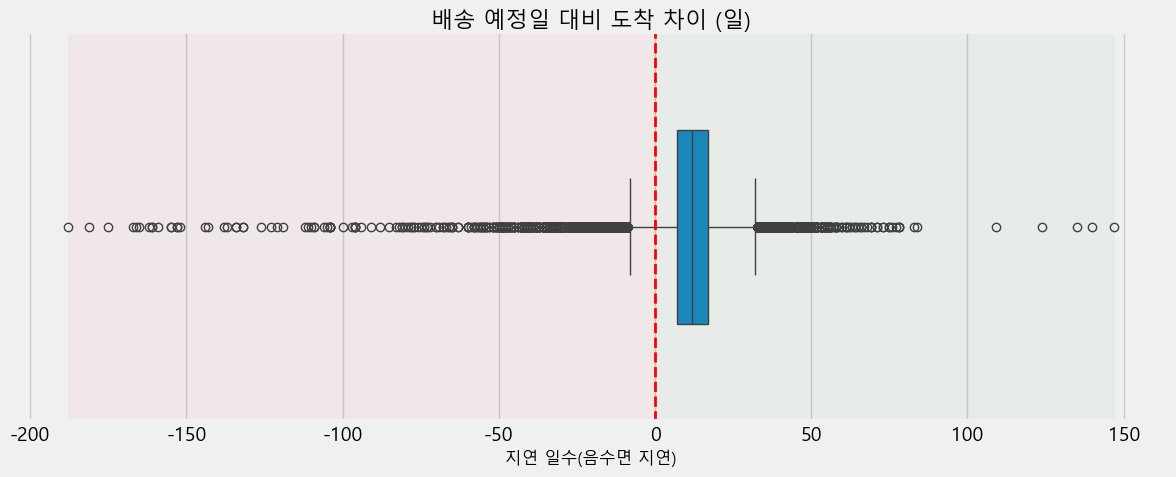

In [85]:
plt.figure(figsize=(12, 5))
sns.boxplot(x=df_orders['delivery_efficiency'], width=0.5)
plt.axvline(x=0, color='red', linestyle='--',linewidth=2)
plt.axvspan(df_orders['delivery_efficiency'].min(), 0, color='red', alpha=0.03)
plt.axvspan(0, df_orders['delivery_efficiency'].max(), color='green', alpha=0.03)

plt.title('배송 예정일 대비 도착 차이 (일)', fontsize=16,pad =2)
plt.xlabel('지연 일수(음수면 지연)', fontsize=12)
plt.tight_layout()
plt.show()

### 2. 결제 데이터
#### 현황 분석

- 결제 수단 중 신용카드가 74% 사용되고, 가장 고액의 금액이 결제됨(금액별 voleto > debit_card > voucher)
- 결제 금액 분포는 평균(154)과 중앙값(100) 차이가 크다(분포가 한쪽으로 치우쳐있다)
- 금액별 세그먼트
- 일반 유저: 0~500헤알 (95% 이하)
- 고가 구매 유저: 500~1000헤알
- VIP 유저: 1000헤알 이상 (99% 이상)
- 결제금액이 0인 값은 voucher나 not_defined 유형으로 실제 결제 금액이 아닌 보조 결제로 판단됨

In [77]:
#분포 파악
print('-----결제 데이터 분포 파악-----\n')
print(df_payments.info())
print(df_payments.payment_type.value_counts())
print(df_payments.payment_type.value_counts(normalize=True)*100)

-----결제 데이터 분포 파악-----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB
None
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64
credit_card    73.922376
boleto         19.043952
voucher         5.558978
debit_card      1.471806
not_defined     0.002888
Name: payment_type, dtype: float64


In [78]:
#결제금액 통계 및 분포
print('-----결제금액 통계 및 분포-----')
print(df_payments.payment_value.describe())

df_payments['payment_value'].quantile([0.01, 0.90,0.95, 0.99])

-----결제금액 통계 및 분포-----
count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64


0.01       6.6900
0.90     297.2700
0.95     437.6350
0.99    1039.9165
Name: payment_value, dtype: float64

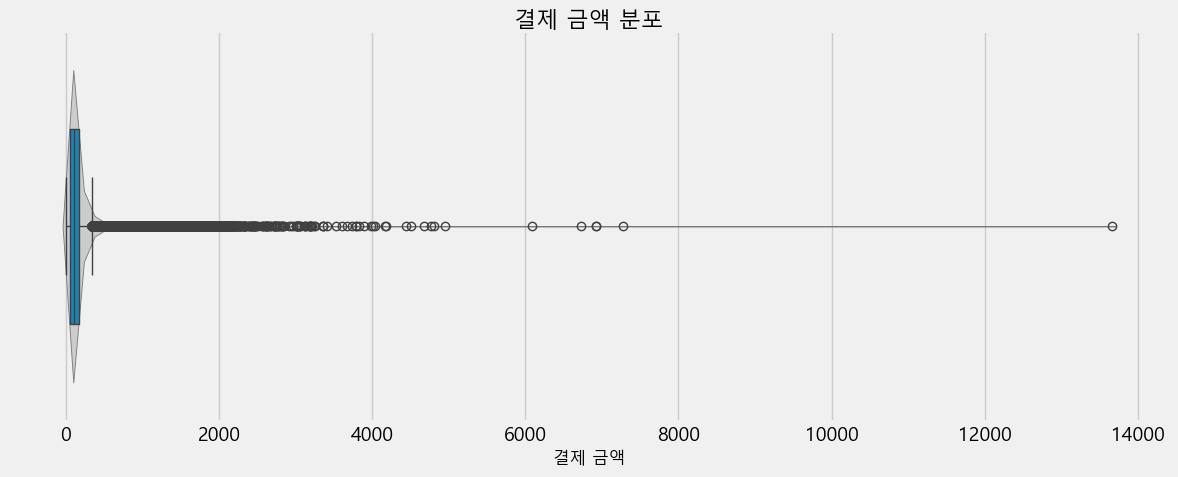

In [87]:
plt.figure(figsize=(12, 5))
sns.violinplot(x=df_payments['payment_value'], inner=None, color=".8")
sns.boxplot(x=df_payments['payment_value'], width = 0.5)
plt.title('결제 금액 분포', fontsize=16, pad=2)
plt.xlabel('결제 금액', fontsize=12)
plt.tight_layout()
plt.show()

In [90]:
#중복 행의 개수
print('결제 데이터의 order_id 고유값 여부: ')
print(df_payments['order_id'].nunique() == len(df_payments))
print('\n결제 데이터의 order_id 중복 갯수: ')
print(len(df_payments) - df_payments['order_id'].nunique())

결제 데이터의 order_id 고유값 여부: 
False

결제 데이터의 order_id 중복값 갯수: 
4446


In [93]:
#결제금액이 최소값(0)인 행은 쿠폰이나 not_defined인 9건의 주문
print(df_payments[df_payments['payment_value']== df_payments['payment_value'].min()])
#not_defined는 금액 정보가 없음
df_payments[df_payments['payment_type']=='not_defined']

                                order_id  payment_sequential payment_type  \
19922   8bcbe01d44d147f901cd3192671144db                   4      voucher   
36822   fa65dad1b0e818e3ccc5cb0e39231352                  14      voucher   
43744   6ccb433e00daae1283ccc956189c82ae                   4      voucher   
51280   4637ca194b6387e2d538dc89b124b0ee                   1  not_defined   
57411   00b1cb0320190ca0daa2c88b35206009                   1  not_defined   
62674   45ed6e85398a87c253db47c2d9f48216                   3      voucher   
77885   fa65dad1b0e818e3ccc5cb0e39231352                  13      voucher   
94427   c8c528189310eaa44a745b8d9d26908b                   1  not_defined   
100766  b23878b3e8eb4d25a158f57d96331b18                   4      voucher   

        payment_installments  payment_value  
19922                      1            0.0  
36822                      1            0.0  
43744                      1            0.0  
51280                      1            0.0  

,order_id,payment_sequential,payment_type,payment_installments,payment_value
51280,4637ca194b6387e2d538dc89b124b0ee,1,not_defined,1,0.0
57411,00b1cb0320190ca0daa2c88b35206009,1,not_defined,1,0.0
94427,c8c528189310eaa44a745b8d9d26908b,1,not_defined,1,0.0


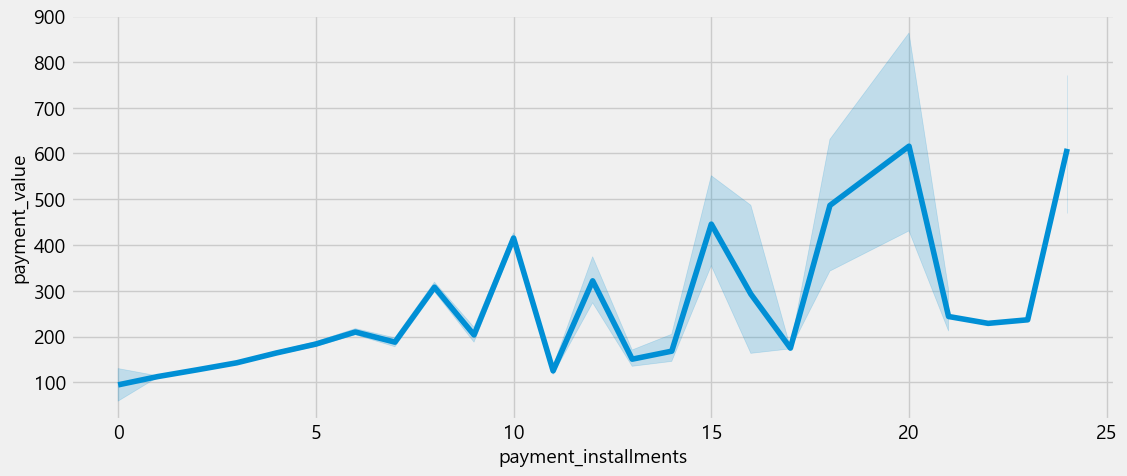

In [94]:
# 할부 횟수와 결제 금액의 관계
#할부 개월수가 많아질 수록 평균 결제 금액이 증가하는 경향이 보이지만,
#변동성이 커서, 설명하기 어려움 
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_payments, x='payment_installments', y='payment_value')
plt.show()

In [95]:
#결제 수단별 결제 금액 비교
##신용카드가 가장 높은 결제 금액을 가짐
print('--결제수단별 결제 금액 평균 값--')
print(df_payments.groupby('payment_type')['payment_value'].mean().sort_values(ascending=False))
print('--결제수단별 결제 금액 중앙 값--')
print(df_payments.groupby('payment_type')['payment_value'].median().sort_values(ascending=False))

--결제수단별 결제 금액 평균 값--
payment_type
credit_card    163.319021
boleto         145.034435
debit_card     142.570170
voucher         65.703354
not_defined      0.000000
Name: payment_value, dtype: float64
--결제수단별 결제 금액 중앙 값--
payment_type
credit_card    106.87
boleto          93.89
debit_card      89.30
voucher         39.28
not_defined      0.00
Name: payment_value, dtype: float64


### 3. 고객 데이터
#### 현황 분석
- customer_unique_id에 6324의 중복 정보 
- customer_id는 주문 단위, customer_unique_id는 고객 단위로, 주문 마다 다른 customer_id 생성 
- 도시별 분포를 보면 고객 수를 보면 대다수의 도시에서 소규모 고객을 보유하고 있으며
- sao paulo 등 소수 대도시에 고객이 집중됨 (sao paulo:15.6%, 상위 5개 도시:약 29%, SP주: 42%)
- 1회 구매자가 약 96.95%로 대부분을 차지하고, 재구매율은 3.04%로 극히 낮다 

#### 다음 분석 방향
- 지역별 배송 기간 차이와 배송 지연 현황 분석 예정

In [27]:
#데이터 분포 및 고유값 확인 
print(df_customers.info())
print(df_customers['customer_id'].nunique() == len(df_customers))
print(df_customers['customer_unique_id'].nunique() == len(df_customers))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
True
False


In [28]:
#customer_unique_id 중복값 정보
df_customers[df_customers['customer_unique_id'].duplicated(keep = False)].sort_values(by='customer_unique_id',ascending=False)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
12133,0088395699ea0fcd459bfbef084997db,ffe254cc039740e17dd15a5305035928,37640,extrema,MG
64323,4b231c90751c27521f7ee27ed2dc3b8f,ffe254cc039740e17dd15a5305035928,37640,extrema,MG
75057,1ae563fdfa500d150be6578066d83998,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,barra bonita,SP
27992,bec0bf00ac5bee64ce8ef5283051a70c,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,barra bonita,SP
79859,d064be88116eb8b958727aec4cf56a59,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,barra bonita,SP
...,...,...,...,...,...
72451,49cf243e0d353cd418ca77868e24a670,004b45ec5c64187465168251cd1c9c2f,57055,maceio,AL
20023,1b4a75b3478138e99902678254b260f4,004288347e5e88a27ded2bb23747066c,26220,nova iguacu,RJ
22066,f6efe5d5c7b85e12355f9d5c3db46da2,004288347e5e88a27ded2bb23747066c,26220,nova iguacu,RJ
35608,24b0e2bd287e47d54d193e7bbb51103f,00172711b30d52eea8b313a7f2cced02,45200,jequie,BA


In [29]:
#지역별 분포
print('고객 거주하는 도시의 수: ', df_customers.customer_city.nunique())
print('고객 거주하는 주의 수: ', df_customers.customer_state.nunique())
print(df_customers['customer_city'].value_counts(normalize=True).head())
print(df_customers['customer_state'].value_counts(normalize=True).head())

고객 거주하는 도시의 수:  4119
고객 거주하는 주의 수:  27
sao paulo         0.156274
rio de janeiro    0.069207
belo horizonte    0.027886
brasilia          0.021430
curitiba          0.015296
Name: customer_city, dtype: float64
SP    0.419807
RJ    0.129242
MG    0.117004
RS    0.054967
PR    0.050734
Name: customer_state, dtype: float64


C:\Users\82109\AppData\Local\Temp\ipykernel_24784\2843077883.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_10_city.values, y=top_10_city.index, palette='Set2')


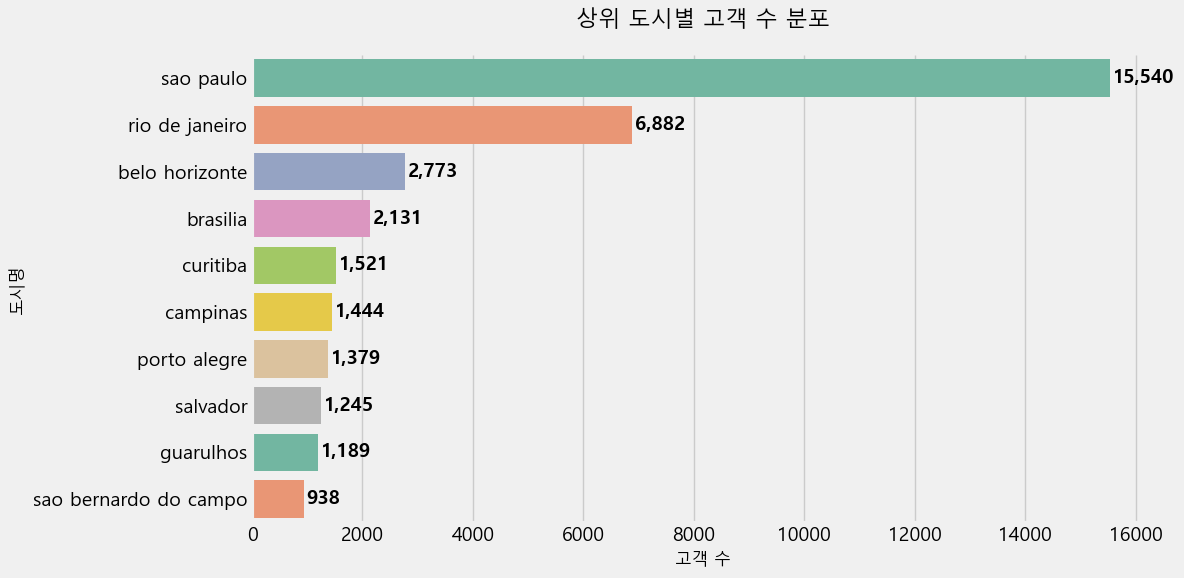

In [122]:
top_10_city = df_customers['customer_city'].value_counts().head(10)

plt.figure(figsize=(12, 6)) # 가로형은 세로 길이를 조금 늘려주는 게 예쁩니다.
# x와 y를 바꿔서 설정합니다.
ax = sns.barplot(x=top_10_city.values, y=top_10_city.index, palette='Set2')

# 수치 표시 위치 조정 (가로 막대이므로 x 좌표에 텍스트 배치)
for i, v in enumerate(top_10_city.values):
    ax.text(v + 50, i, f'{v:,}', va='center', fontweight='bold')

plt.title('상위 도시별 고객 수 분포', fontsize=16, pad=20)
plt.xlabel('고객 수', fontsize=12)
plt.ylabel('도시명', fontsize=12)
sns.despine() # 테두리 제거로 깔끔하게
plt.tight_layout()
plt.show()

C:\Users\82109\AppData\Local\Temp\ipykernel_24784\371991064.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_states.index, y=top_10_states.values, palette='Set2')


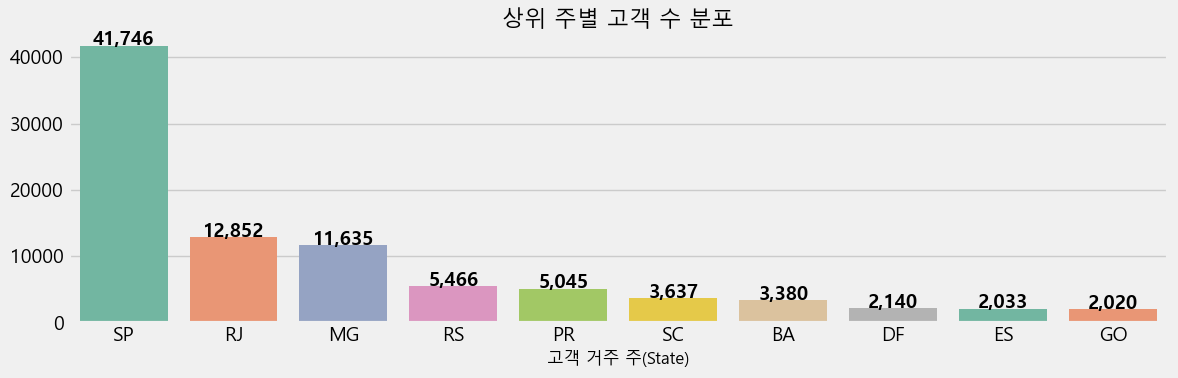

In [117]:
top_10_states = df_customers['customer_state'].value_counts().head(10)
plt.figure(figsize=(12,4))
sns.barplot(x=top_10_states.index, y=top_10_states.values, palette='Set2')
for i, v in enumerate(top_10_states.values):
    plt.text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')
plt.title('상위 주별 고객 수 분포', fontsize= 16, pad=2)
plt.xlabel('고객 거주 주(State)',fontsize=12)
plt.tight_layout()
plt.show()

In [31]:
#전체 재구매율 
df_orders_customers = pd.merge(df_orders,df_customers[['customer_id','customer_unique_id']], on='customer_id')
df_clean = df_orders_customers[~df_orders_customers['order_status'].isin(['canceled', 'unavailable'])].copy()

user_order_counts = df_clean.groupby('customer_unique_id')['order_id'].nunique().reset_index()
user_order_counts.columns = ['customer_unique_id', 'order_count']

#재구매여부 판별
user_order_counts['is_repurchase'] = (user_order_counts['order_count'] > 1).astype(int)

#전체 재구매율 계산
total_users = len(user_order_counts)
repurchase_users = user_order_counts['is_repurchase'].sum()
total_repurchase_rate = (repurchase_users / total_users) * 100

print(f"전체 재구매율: {total_repurchase_rate:.2f}")

전체 재구매율: 3.04


In [32]:
#구매 횟수 분포
print(user_order_counts['order_count'].value_counts())
print(user_order_counts['order_count'].value_counts(normalize=True))

1     92102
2      2652
3       188
4        29
5         9
6         5
7         3
9         1
16        1
Name: order_count, dtype: int64
1     0.969597
2     0.027919
3     0.001979
4     0.000305
5     0.000095
6     0.000053
7     0.000032
9     0.000011
16    0.000011
Name: order_count, dtype: float64


### 4 주문 아이템 데이터
#### 현황 분석

- order_id에 중복된 값이 있음
    - 하나의 order_id에 여러개의 order_item_id가 존재하여 주문한 상품의 순번을 나타냄

- 상품 가격 분포를 보면, 대부분의 상품은 저~중가에 몰려있음
    - 평균 가격 약 120.65헤알, 중앙값은 약 74.99헤알
- 배송비 분포도 긴 우측 꼬리 가짐
    - 평균은 약 19.99헤알, 중앙값은 16.26헤알
    
- 전체의 약 97% 고객이 한 주문 당 3개 이하로 구매 (전체의 87%의 고객이 1개 구매)
- 셀러 처리 지연은 약 9%로 10413건 존재

#### 앞으로 분석 방향

- 셀러의 처리 지연이 전체 배송 지연에 미치는 영향을 분석할 필요가 있음

In [33]:
print(df_items.info())
print(df_items['order_item_id'].value_counts())
print(df_items['order_item_id'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB
None
1     98666
2      9803
3      2287
4       965
5       460
6       256
7        58
8        36
9        28
10       25
11       17
12       13
13        8
14        7
15        5
16        3
17        3
18        3
19        3
20        3
21        1
Name: order_item_id, dtype: int64
1     0.875863
2     0.087022
3     0.020302
4     0.008566
5     0.004083
6  

In [34]:
#날짜형 변환
df_items['shipping_limit_date']= pd.to_datetime(df_items['shipping_limit_date'])

In [35]:
df_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_efficiency,is_delayed
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.0,0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,6.0,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,18.0,0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,13.0,0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,10.0,0
...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,11.0,0
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,2.0,0
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,6.0,0
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,21.0,0


In [36]:
#취소값 제외
df_orders_f = df_orders[~df_orders['order_status'].isin(['canceled', 'unavailable'])].copy()

#병합
df_orders_items = pd.merge(df_orders_f,df_items[['order_id', 'shipping_limit_date']], on='order_id', how='left')

#지연여부
df_orders_items['late_process'] = (df_orders_items['order_delivered_carrier_date'] > df_orders_items['shipping_limit_date']).map({
    True: '지연', False: '정상'
})
print(df_orders_items['late_process'].value_counts())
print(df_orders_items['late_process'].value_counts(normalize=True))

정상    101696
지연     10413
Name: late_process, dtype: int64
정상    0.907117
지연    0.092883
Name: late_process, dtype: float64


In [37]:
#가격과 배송비 분포
print(df_items['price'].describe())
print(df_items['freight_value'].describe())

count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64
count    112650.000000
mean         19.990320
std          15.806405
min           0.000000
25%          13.080000
50%          16.260000
75%          21.150000
max         409.680000
Name: freight_value, dtype: float64


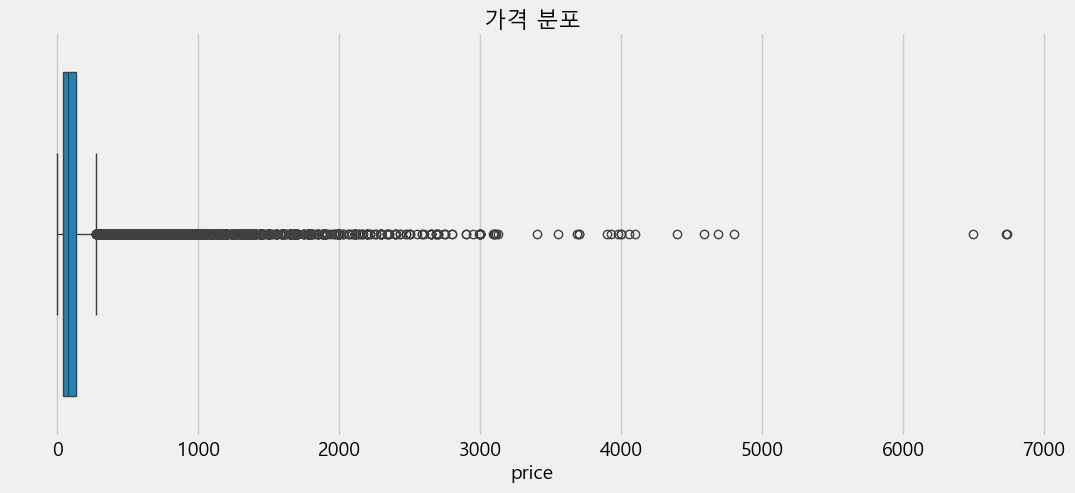

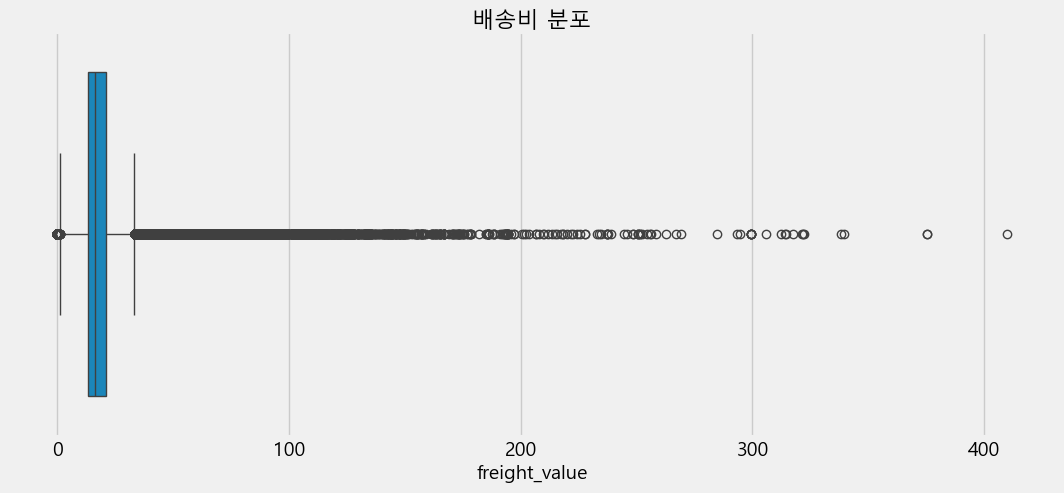

In [125]:
plt.figure(figsize=(12,5))
sns.boxplot(x='price', data=df_items)
plt.title('가격 분포',fontsize=16,pad=2)
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x='freight_value', data=df_items)
plt.title('배송비 분포',fontsize=16,pad=2)
plt.show()

### 5. 리뷰 데이터
#### 현황 분석
   
- 주문 아이디와 리뷰 아이디는 다대다 관계(N:M)
    - 1. 하나의 주문 ID - 여러개의 리뷰 ID
    - 2. 여러 주문 ID - 하나의 리뷰 ID
- 하나의 주문에, 리뷰가 중복되면 평균을 구할 때 영향을 주기 때문에, 가장 최신 시점의 리뷰를 채택

- 리뷰 점수는 전반적으로 높으나, 불만족 고객(1점)이 중간 만족(2~3점) 고객보다 더 많이 존재하는 양극화된 분포를 보임 


#### 다음 분석 방향
- 배송의 지연 상태가 리뷰점수에 어떤 영향을 주는지 분석이 필요함

In [39]:
#분포 확인
print(df_reviews.info())

#리뷰 아이디 중복 확인
review_per_order = df_reviews.groupby('order_id')['review_id'].nunique()
print(review_per_order.value_counts())

#주문 아이디 중복 확인
print(df_reviews['order_id'].nunique())
print(df_reviews['review_id'].nunique())

order_per_review = df_reviews.groupby('review_id')['order_id'].nunique()
print(order_per_review.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
None
1    98126
2      543
3        4
Name: review_id, dtype: int64
98673
98410
1    97621
2      764
3       25
Name: order_id, dtype: int64


In [40]:
df_reviews_f = df_reviews.sort_values('review_answer_timestamp').drop_duplicates('order_id', keep='last')

print(df_reviews_f['review_score'].value_counts())
print(df_reviews_f['review_score'].value_counts(normalize=True))

5    57008
4    19038
1    11363
3     8133
2     3131
Name: review_score, dtype: int64
5    0.577747
4    0.192940
1    0.115158
3    0.082424
2    0.031731
Name: review_score, dtype: float64


In [41]:
# 하나의 주문 ID - 여러개의 리뷰 ID
# 점수 그대로: 보강하거나, 리뷰를 더 구체화 / 점수 변화: 실제 사용 후 경험 변화

review_per_order = df_reviews.groupby('order_id')['review_id'].nunique()
multi_review_order = review_per_order[review_per_order > 1].index
df_multi_reviews = df_reviews[df_reviews['order_id'].isin(multi_review_order)].sort_values(['order_id', 'review_answer_timestamp'])

review_diff = df_multi_reviews.groupby('order_id')['review_score'].agg(['first', 'last'])

conditions = [
review_diff['last'] > review_diff['first'],
review_diff['last'] < review_diff['first']
]

choices = ['Increased', 'Decreased']
review_diff['change_type'] = np.select(conditions, choices, default='No Change')
review_diff['change_type'].value_counts()

No Change    346
Decreased    113
Increased     88
Name: change_type, dtype: int64

### 6. 제품 데이터
#### 현황 분석
- 총 73개의 카테고리, 32951개의 제품이 있음

In [42]:
#데이터 분포
df_products.info()
#고유값 확인
df_products[df_products['product_id'].duplicated()]
#카테고리 갯수
print(f"카테고리 갯수: {df_products['product_category_name'].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB
카테고리 갯수: 73


In [43]:
#카테고리별 상품 분포
print(df_products['product_category_name'].value_counts().head(10))

cama_mesa_banho           3029
esporte_lazer             2867
moveis_decoracao          2657
beleza_saude              2444
utilidades_domesticas     2335
automotivo                1900
informatica_acessorios    1639
brinquedos                1411
relogios_presentes        1329
telefonia                 1134
Name: product_category_name, dtype: int64


In [44]:
#카테고리별 매출 순위
df_items_products = df_items.merge(
                    df_products[['product_id', 'product_category_name']], 
                    on = 'product_id',
                    how='left')

df_items_products['revenue']= df_items_products['price'] + df_items_products['freight_value']                                                
category_revenue = df_items_products.groupby('product_category_name')['revenue'].sum().sort_values(ascending=False)
category_revenue.head(20)

product_category_name
beleza_saude              1441248.07
relogios_presentes        1305541.61
cama_mesa_banho           1241681.72
esporte_lazer             1156656.48
informatica_acessorios    1059272.40
moveis_decoracao           902511.79
utilidades_domesticas      778397.77
cool_stuff                 719329.95
automotivo                 685384.32
ferramentas_jardim         584219.21
brinquedos                 561372.55
bebes                      480118.00
perfumaria                 453338.71
telefonia                  394883.32
moveis_escritorio          342532.65
papelaria                  277741.71
pet_shop                   253876.65
pcs                        232799.43
instrumentos_musicais      210137.37
eletronicos                206825.06
Name: revenue, dtype: float64

### 7. 셀러 데이터
#### 현황 분석
- 3095명의 셀러 존재
- 셀러는 도시 기준 sao paulo에 약 22%가 집중되어 있으며,
- 주(state) 기준으로는 SP가 전체의 약 60%를 차지해 셀러가 특정 지역에 편중된 구조임을 확인

In [45]:
#셀러 지역 분포
df_sellers.info()
print(df_sellers['seller_city'].value_counts().head(10))
print(df_sellers['seller_state'].value_counts().head(10))
print(df_sellers['seller_city'].value_counts(normalize=True).head(10))
print(df_sellers['seller_state'].value_counts(normalize=True).head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB
sao paulo         694
curitiba          127
rio de janeiro     96
belo horizonte     68
ribeirao preto     52
guarulhos          50
ibitinga           49
santo andre        45
campinas           41
maringa            40
Name: seller_city, dtype: int64
SP    1849
PR     349
MG     244
SC     190
RJ     171
RS     129
GO      40
DF      30
ES      23
BA      19
Name: seller_state, dtype: int64
sao paulo         0.224233
curitiba          0.041034
rio de janeiro    0.031018
belo horizonte    0.021971
ribeirao preto    0.016801
g

In [46]:
# 저장할 데이터프레임 리스트
dataframes = {
    'customers': df_customers,
    'geolocation': df_geolocation,
    'orders': df_orders,
    'items': df_items,
    'payments': df_payments,
    'reviews': df_reviews,
    'products': df_products,
    'sellers': df_sellers
}

# 하나씩 Pickle로 저장
for name, dframe in dataframes.items():
    dframe.to_pickle(f'cleaned_{name}.pkl')
    print(f'cleaned_{name}.pkl 저장 완료!')

cleaned_customers.pkl 저장 완료!
cleaned_geolocation.pkl 저장 완료!
cleaned_orders.pkl 저장 완료!
cleaned_items.pkl 저장 완료!
cleaned_payments.pkl 저장 완료!
cleaned_reviews.pkl 저장 완료!
cleaned_products.pkl 저장 완료!
cleaned_sellers.pkl 저장 완료!
